In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

### Lendo os dados

In [2]:
df_DailyLife             = pd.read_csv('Data/weighted-survey-data-2012/DailyLife.csv')
df_Discrimination        = pd.read_csv('Data/weighted-survey-data-2012/Discrimination.csv')
df_RightsAwareness       = pd.read_csv('Data/weighted-survey-data-2012/RightsAwareness.csv')
df_ViolenceAndHarassment = pd.read_csv('Data/weighted-survey-data-2012/ViolenceAndHarassment.csv')
df_HDI                   = pd.read_csv('Data/cleaned-survey-data-2012/HDI_EU-2012.csv')

df_DailyLife.head()

,CountryName,subset,question_code,question_label,answer,percentage,weight
0,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Very widespread,8.0,-1.0
1,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Fairly widespread,34.0,-0.5
2,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Fairly rare,45.0,0.5
3,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Very rare,9.0,1.0
4,Austria,Gay,b1_a,"In your opinion, how widespread is offensive l...",Very widespread,4.0,-1.0


### Modificando os dados

- Criaremos uma coluna auxiliar que significa percentage * weight

In [3]:
def create_score(df):
    df['score'] = df.apply(lambda row: row['weight'] * (row['percentage'] / 100), axis=1)
    
create_score(df_DailyLife)
create_score(df_Discrimination)
create_score(df_RightsAwareness)
create_score(df_ViolenceAndHarassment)

df_DailyLife.head()

,CountryName,subset,question_code,question_label,answer,percentage,weight,score
0,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Very widespread,8.0,-1.0,-0.080
1,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Fairly widespread,34.0,-0.5,-0.170
2,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Fairly rare,45.0,0.5,0.225
3,Austria,Lesbian,b1_a,"In your opinion, how widespread is offensive l...",Very rare,9.0,1.0,0.090
4,Austria,Gay,b1_a,"In your opinion, how widespread is offensive l...",Very widespread,4.0,-1.0,-0.040


### Limpando os dados

- Removeremos as colunas desnecessárias para as análises

In [4]:
def clean_df(df):
    return df[['CountryName', 'score']]

df_DailyLife = clean_df(df_DailyLife)
df_Discrimination = clean_df(df_Discrimination)
df_RightsAwareness = clean_df(df_RightsAwareness)
df_ViolenceAndHarassment = clean_df(df_ViolenceAndHarassment)

df_DailyLife.head()

,CountryName,score
0,Austria,-0.080
1,Austria,-0.170
2,Austria,0.225
3,Austria,0.090
4,Austria,-0.040


### Agrupando os dados por país, somando os _scores_

In [5]:
group_DailyLife             = df_DailyLife.groupby('CountryName').sum()
group_Discrimination        = df_Discrimination.groupby('CountryName').sum()
group_RightsAwareness       = df_RightsAwareness.groupby('CountryName').sum()
group_ViolenceAndHarassment = df_ViolenceAndHarassment.groupby('CountryName').sum()

group_DailyLife.head()

,score
CountryName,
Austria,-1.540
Average,-4.445
Belgium,12.170
Bulgaria,-22.960
Croatia,-26.450


### Somando todos os _scores_, resultando no _score_ final para cada país

In [6]:
final_weight_per_country = group_DailyLife + group_Discrimination + group_RightsAwareness + group_ViolenceAndHarassment
final_weight_per_country = final_weight_per_country.reset_index()
final_weight_per_country.head()

,CountryName,score
0,Austria,13.9665
1,Average,2.2569
2,Belgium,28.2459
3,Bulgaria,-34.6853
4,Croatia,-19.3698


### Criando tuplas (IDH, _score_) por país

In [7]:
# Modificando o nome da coluna Country para CountryName
df_HDI.rename(columns={'Country': 'CountryName', '2012': 'HDI-2012'}, inplace=True)

# Realizando um merge entre os dataframes
df_merged = pd.merge(df_HDI, final_weight_per_country)

df_merged.head()

,CountryName,HDI-2012,score
0,Bulgaria,0.786,-34.6853
1,Romania,0.795,-32.8909
2,Croatia,0.816,-19.3698
3,Latvia,0.824,-17.8596
4,Portugal,0.829,4.5956


In [8]:
print('Melhor score [País, IDH, score]:', df_merged.iloc[df_merged['score'].idxmax()].tolist())
print('Pior score [País, IDH, score]:', df_merged.iloc[df_merged['score'].idxmin()].tolist())

Melhor score [País, IDH, score]: ['Netherlands', 0.9209999999999999, 39.946199999999976]
Pior score [País, IDH, score]: ['Bulgaria', 0.7859999999999999, -34.685300000000005]


- Percebemos que o país com melhor score total é a Holanda; já o com pior é a Bulgária.

### Realizando a regressão

D:\Anaconda\envs\ICD\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


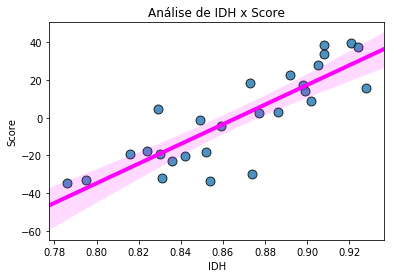

Model slope: 521.7607437129213
Model intercept: -452.16056968129385
Model rvalue: 0.8466715251506688
Model pvalue: 2.5996612706523036e-08


In [9]:
# Realizando a regressão sobre os dados
sns.regplot(x='HDI-2012', y='score', data=df_merged, n_boot=10000,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})

plt.title('Análise de IDH x Score')
plt.xlabel('IDH')
plt.ylabel('Score')
plt.show()

# Recuperando os dados do modelo (slope, intercept, correlação de pearson, pvalue)
model = ss.linregress(df_merged['HDI-2012'], df_merged['score'])
print('Model slope:', model.slope)
print('Model intercept:', model.intercept)
print('Model rvalue:', model.rvalue)
print('Model pvalue:', model.pvalue)

- Percebemos que os nossos dados possuem uma correlação de Pearson igual a $\approx$ 0.85.
- Com isso, temos que nossos dados possuem uma correlação positiva, e com o aumento do IDH do país, explica relativamente bem, um aumento do score.

## Analisando a correlação para cada DataFrame específico

### Função auxiliar para facilitar a análise dos dados

In [10]:
def show_regression_result(group):
    # Modificando o nome da coluna Country para CountryName
    df_HDI.rename(columns={'Country': 'CountryName', '2012': 'HDI-2012'}, inplace=True)

    # Realizando um merge entre os dataframes
    df_merged = pd.merge(df_HDI, group.reset_index())
    
    print('Melhor score [País, IDH, score]:', df_merged.iloc[df_merged['score'].idxmax()].tolist())
    print('Pior score [País, IDH, score]:', df_merged.iloc[df_merged['score'].idxmin()].tolist())
    
    # Realizando a regressão sobre os dados
    sns.regplot(x='HDI-2012', y='score', data=df_merged, n_boot=10000,
                line_kws={'color':'magenta', 'lw':4},
                scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})

    plt.title('Análise de IDH x Score')
    plt.xlabel('IDH')
    plt.ylabel('Score')
    plt.show()

    # Recuperando os dados do modelo (slope, intercept, correlação de pearson, pvalue)
    model = ss.linregress(df_merged['HDI-2012'], df_merged['score'])
    print('Model slope:', model.slope)
    print('Model intercept:', model.intercept)
    print('Model rvalue:', model.rvalue)
    print('Model pvalue:', model.pvalue)

### DailyLife

Melhor score [País, IDH, score]: ['Netherlands', 0.9209999999999999, 17.445]
Pior score [País, IDH, score]: ['Croatia', 0.816, -26.450000000000028]


D:\Anaconda\envs\ICD\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


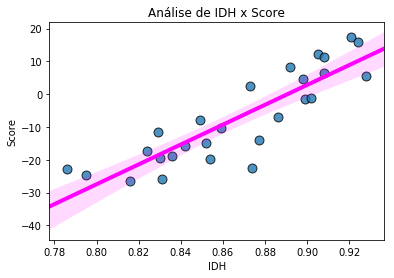

Model slope: 302.9383963002465
Model intercept: -269.83046654196914
Model rvalue: 0.8747502091834355
Model pvalue: 2.4318474100523823e-09


In [11]:
show_regression_result(group_DailyLife)

- Percebemos que o país com melhor score para o dados de DailyLife é a Holanda; já o com pior é a Croácia.
- O valor da correlação de Pearson igual a $\approx$ 0.87.
- Com isso, temos que nossos dados possuem uma correlação positiva, e com o aumento do IDH do país, explica relativamente bem, um aumento do score para os dados de DailyLife.

### Discrimination

Melhor score [País, IDH, score]: ['Malta', 0.8490000000000001, -0.9]
Pior score [País, IDH, score]: ['United Kingdom', 0.898, -3.7400000000000007]


D:\Anaconda\envs\ICD\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


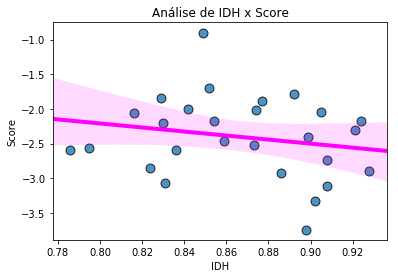

Model slope: -2.9084626892423473
Model intercept: 0.11674851862564584
Model rvalue: -0.19840616441617864
Model pvalue: 0.3211615059012022


In [12]:
show_regression_result(group_Discrimination)

- Percebemos que o país com melhor score para o dados de Discrimination é Malta; já o com pior é o Reino Unido.
- O valor da correlação de Pearson igual a $\approx$ 0.12.
- Com isso, temos que nossos dados possuem uma correlação positiva, porém, muito baixa. Com isso, um aumento do IDH do país, não consegue explicar, um aumento do score para os dados de Discrimination.

### RightsAwareness

Melhor score [País, IDH, score]: ['Sweden', 0.9079999999999999, 33.980000000000004]
Pior score [País, IDH, score]: ['Greece', 0.8540000000000001, -2.9399999999999995]


D:\Anaconda\envs\ICD\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


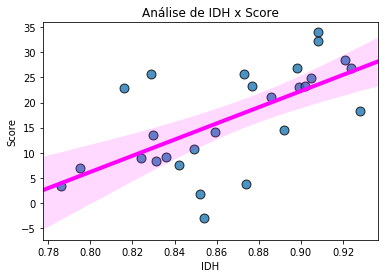

Model slope: 161.23591607408719
Model intercept: -122.82214682598119
Model rvalue: 0.6364876791067295
Model pvalue: 0.00035813000843420875


In [13]:
show_regression_result(group_RightsAwareness)

- Percebemos que o país com melhor score para o dados de RightsAwareness é a Suécia; já o com pior é a Grécia.
- O valor da correlação de Pearson igual a $\approx$ 0.64.
- Com isso, temos que nossos dados possuem uma correlação positiva, porém, não tão alta. Com isso, um aumento do IDH do país, consegue explicar de forma razoável, um aumento do score para os dados de RightsAwareness.

### ViolenceAndHarassment

Melhor score [País, IDH, score]: ['Luxembourg', 0.892, 1.7787000000000002]
Pior score [País, IDH, score]: ['Croatia', 0.816, -13.6898]


D:\Anaconda\envs\ICD\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


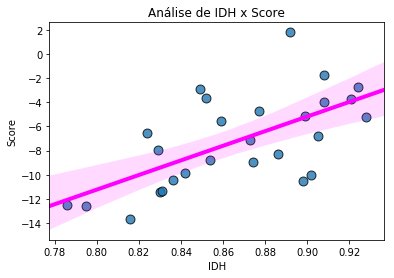

Model slope: 60.49489402782982
Model intercept: -59.62470483196897
Model rvalue: 0.6337424793827473
Model pvalue: 0.0003866934384392839


In [14]:
show_regression_result(group_ViolenceAndHarassment)

- Percebemos que o país com melhor score para o dados de ViolenceAndHarassment é Luxemburgo; já o com pior é a Croácia.
- O valor da correlação de Pearson igual a $\approx$ 0.63.
- Com isso, temos que nossos dados possuem uma correlação positiva, porém, não tão alta. Com isso, um aumento do IDH do país, consegue explicar de forma razoável, um aumento do score para os dados de ViolenceAndHarassment.